## Imports

In [67]:
import sys
sys.path.append("..")

In [68]:
from snowflake.snowpark import Session
from snowflake.snowpark.functions import when, col, count, upper
from datetime import date
from helpers import SnowflakeHelper
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
snowflake_helper = SnowflakeHelper()
snowflake_config = './../helpers/snowflake_config.json'
session = snowflake_helper.create_snowpark_session(snowflake_config)

[INFO] No schema passed, using default schema SAFEGUARDING_NYC_SCHEMA_BRONZE for the session
[SUCCESS] Config file loaded successfully!
[SUCCESS] Snowspark Session created successfully on schema SAFEGUARDING_NYC_SCHEMA_BRONZE!


## Extracting Data

In [70]:
use_of_force_combined = session.table('SAFEGUARDING_NYC_SCHEMA_GOLD.use_of_force_combined')
NYPD_PRECINCTS_NEIGHBORHOODS = session.table('SAFEGUARDING_NYC_SCHEMA_GOLD.NYPD_PRECINCTS_NEIGHBORHOODS')

In [71]:
use_of_force_combined.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"FORCETYPE"        |"INCIDENT PCT"  |"TRI INCIDENT NUMBER"  |"PATROL BOROUGH"  |"OCCURRENCE DATE"  |"FORCE AGAINST MOS"  |"AGE"  |"SUBJECT GENDER"  |"SUBJECT RACE"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
|Physical Force     |1               |2020020962067          |MANHATTAN         |2020-05-06         |Physical Force       |NULL   |MALE              |BLACK           |
|Physical Force     |1               |2020020962143          |MANHATTAN         |2020-10-11         |Physical Force       |NULL   |MALE              |BLACK           |
|Physical Force     |5               |2020024962080          |MANHATTAN         |2020-06-30         |Physical Force       |NULL   |MALE              |BLACK     

In [72]:
use_of_force_combined.count()

29723

In [73]:
NYPD_PRECINCTS_NEIGHBORHOODS.show()

-------------------------------------------------------------------
|"NEIGHBORHOODS"                                     |"PRECINCT"  |
-------------------------------------------------------------------
|World Trade Center/SOHO/Tribeca/Wall Street.        |1           |
|Chinatown/Little Italy                              |5           |
|Greenwich Village/West Village                      |6           |
|Williamsburg Bridge/Orchard Street                  |7           |
|East Village                                        |9           |
|Chelsea, Clinton/Hell's Kitchen South/Hudson Yards  |10          |
|Peter Cooper Village/Stuyvesant Town residentia...  |13          |
|Sutton Area/Beekman Place/Kipps Bay/Turtle Bay/...  |17          |
|Madison/Lexington/3rd Avenues                       |19          |
|Lincoln Center for the Performing Arts/the Amer...  |20          |
-------------------------------------------------------------------



## Join Use of Force with Neighborhoods

In [74]:
use_of_force_combined_with_neighborhoods = use_of_force_combined.join(
    NYPD_PRECINCTS_NEIGHBORHOODS, 
    use_of_force_combined['INCIDENT PCT'] == NYPD_PRECINCTS_NEIGHBORHOODS['PRECINCT'], 
    how="left"
)
use_of_force_combined_with_neighborhoods.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"FORCETYPE"        |"INCIDENT PCT"  |"TRI INCIDENT NUMBER"  |"PATROL BOROUGH"  |"OCCURRENCE DATE"  |"FORCE AGAINST MOS"  |"AGE"  |"SUBJECT GENDER"  |"SUBJECT RACE"  |"NEIGHBORHOODS"                                     |"PRECINCT"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|Physical Force     |1               |2020020962067          |MANHATTAN         |2020-05-06         |Physical Force       |NULL   |MALE              |BLACK           |World Trade Center/SOHO/Tribeca/Wall Street.        |1           |
|Physical Force     |1               |2020020962143          |MA

In [75]:
use_of_force_combined_with_neighborhoods.count()

29723

## Convert Snowspark df to Pandas df

In [76]:
data = use_of_force_combined_with_neighborhoods.collect()

In [77]:
use_of_force_combined_with_neighborhoods_pandas_df = pd.DataFrame(data, columns=[col.name for col in use_of_force_combined_with_neighborhoods.schema.fields])

In [78]:
use_of_force_combined_with_neighborhoods_pandas_df.head()

,FORCETYPE,"""INCIDENT PCT""","""TRI INCIDENT NUMBER""","""PATROL BOROUGH""","""OCCURRENCE DATE""","""FORCE AGAINST MOS""",AGE,"""SUBJECT GENDER""","""SUBJECT RACE""",NEIGHBORHOODS,PRECINCT
0,Physical Force,1,2020020962067,MANHATTAN,2020-05-06,Physical Force,None,MALE,BLACK,World Trade Center/SOHO/Tribeca/Wall Street.,1
1,Physical Force,1,2020020962143,MANHATTAN,2020-10-11,Physical Force,None,MALE,BLACK,World Trade Center/SOHO/Tribeca/Wall Street.,1
2,Physical Force,5,2020024962080,MANHATTAN,2020-06-30,Physical Force,None,MALE,BLACK,Chinatown/Little Italy,5
3,Electrical Weapon,6,2020025962038,MANHATTAN,2020-03-02,Physical Force,None,MALE,BLACK,Greenwich Village/West Village,6
4,Physical Force,6,2020025962049,MANHATTAN,2020-03-25,Physical Force,None,MALE,BLACK,Greenwich Village/West Village,6


## Column Transformations

### Convert OCCURENCE DATE to pandas datetime

In [79]:
use_of_force_combined_with_neighborhoods_pandas_df['"OCCURRENCE DATE"'] = pd.to_datetime(use_of_force_combined_with_neighborhoods_pandas_df['"OCCURRENCE DATE"'])

### Make a new column "Age Categories"

In [82]:
age_bins = [0, 18, 25, 45, 65, float('inf')]
age_labels = ['<18', '18-24', '25-44', '45-64', '65+']

use_of_force_combined_with_neighborhoods_pandas_df['Age Category'] = pd.cut(
    pd.to_numeric(use_of_force_combined_with_neighborhoods_pandas_df['AGE'], errors='coerce'),
    bins=age_bins,
    labels=age_labels,
    right=False  # Include the right bin edge in the interval
)

# Handle null values by assigning a category 'Unknown' or any other desired category
use_of_force_combined_with_neighborhoods_pandas_df['Age Category'] = use_of_force_combined_with_neighborhoods_pandas_df['Age Category'].cat.add_categories('Unknown')
use_of_force_combined_with_neighborhoods_pandas_df['Age Category'].fillna('Unknown', inplace=True)

In [83]:
use_of_force_combined_with_neighborhoods_pandas_df['Age Category'].value_counts()

Age Category
25-44      16194
18-24       6702
45-64       3114
<18         2333
Unknown     1207
65+          173
Name: count, dtype: int64

### Categorize to Weapons or Others

In [84]:
categories_to_combine = ['Displayed Weapon', 'Impact Weapon', 'Cutting Instrument', 'Firearm']
use_of_force_combined_with_neighborhoods_pandas_df['"FORCE AGAINST MOS"'] = use_of_force_combined_with_neighborhoods_pandas_df['"FORCE AGAINST MOS"'].replace(categories_to_combine, 'Weapons')

## EDA

### Weapons based EDA

#### Make a new weapons_df

In [85]:
weapons_df = use_of_force_combined_with_neighborhoods_pandas_df[use_of_force_combined_with_neighborhoods_pandas_df['"FORCE AGAINST MOS"'] == 'Weapons']

#### Distribution of Weapons Found Among Different Races

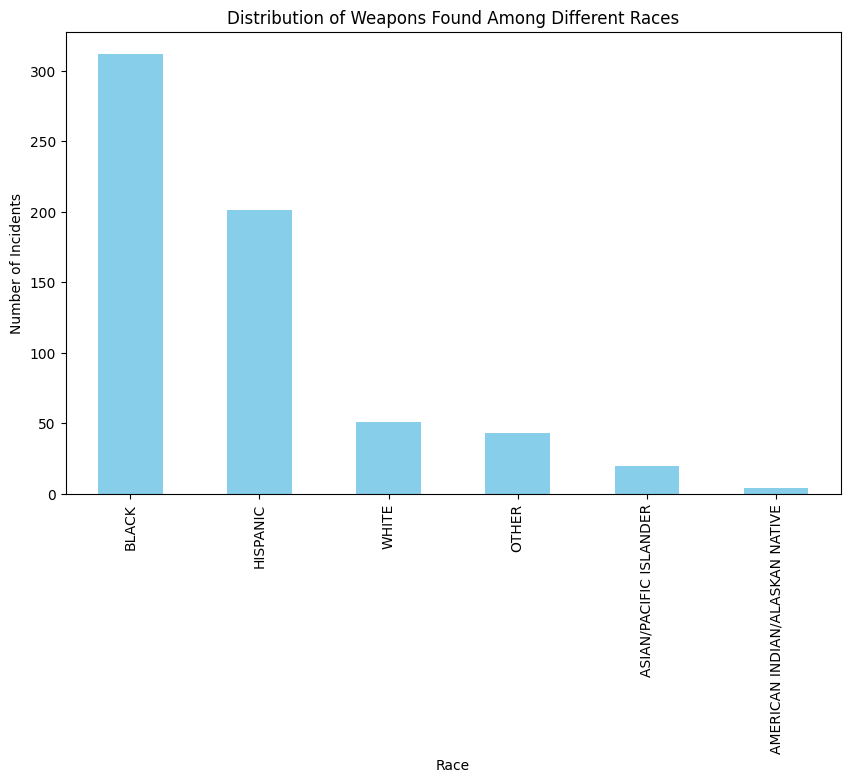

In [86]:
# Plot the distribution of 'Weapons' force against MOS among different races
plt.figure(figsize=(10, 6))
weapons_df['"SUBJECT RACE"'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Weapons Found Among Different Races')
plt.xlabel('Race')
plt.ylabel('Number of Incidents')
plt.show()

#### Top 5 Neighborhoods in Each Borough by Number of Weapons Incidents

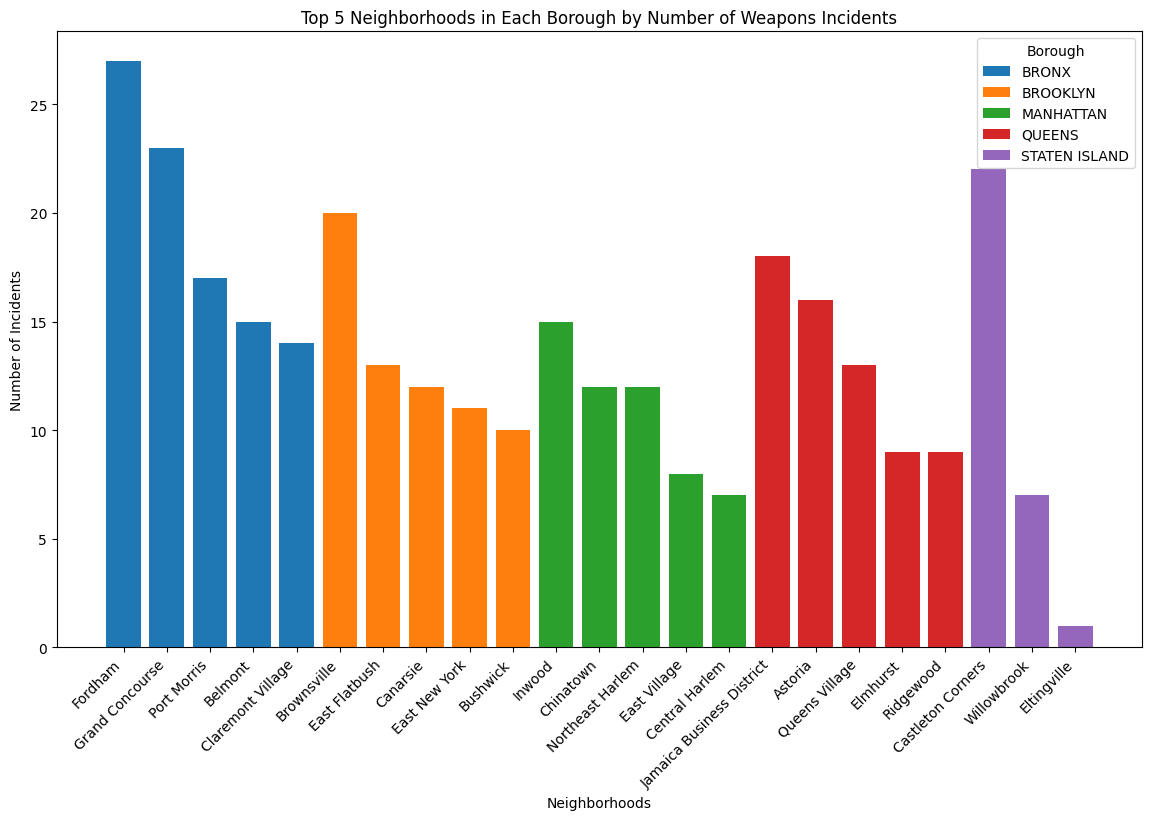

In [87]:
borough_neighborhood_counts = weapons_df.groupby(['"PATROL BOROUGH"', 'NEIGHBORHOODS']).size().reset_index(name='Number of Incidents')

# Sort the values within each borough group and get the top 10 neighborhoods
top_neighborhoods_per_borough = borough_neighborhood_counts.groupby('"PATROL BOROUGH"').apply(lambda x: x.nlargest(5, 'Number of Incidents')).reset_index(drop=True)

top_neighborhoods_per_borough['Short Neighborhood'] = top_neighborhoods_per_borough['NEIGHBORHOODS'].apply(lambda x: x.split('/')[0].strip())

# Plot the data
plt.figure(figsize=(14, 8))
for borough, data in top_neighborhoods_per_borough.groupby('"PATROL BOROUGH"'):
    plt.bar(data['Short Neighborhood'], data['Number of Incidents'], label=borough)

plt.title('Top 5 Neighborhoods in Each Borough by Number of Weapons Incidents')
plt.xlabel('Neighborhoods')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Borough')
plt.show()

#### Age Category Distribution for Weapons Found

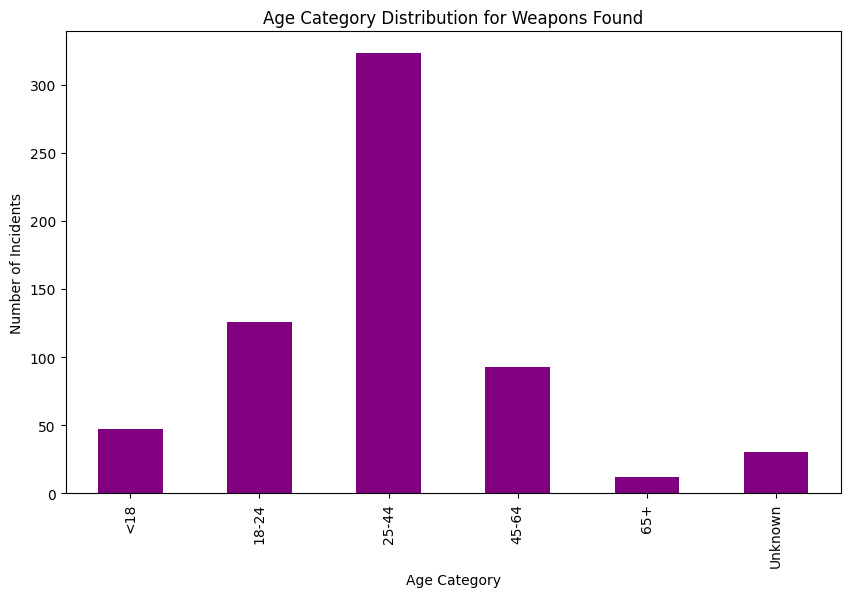

In [88]:
plt.figure(figsize=(10, 6))
weapons_df['Age Category'].value_counts().sort_index().plot(kind='bar', color='purple')
plt.title('Age Category Distribution for Weapons Found')
plt.xlabel('Age Category')
plt.ylabel('Number of Incidents')
plt.show()

#### Distribution of Weapons Found Along the Day of the Week

/var/folders/05/g8zq9hzd1mb9q7x9_5v4rpw00000gn/T/ipykernel_1211/334278265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weapons_df['Day of Week'] = weapons_df['"OCCURRENCE DATE"'].dt.day_name()


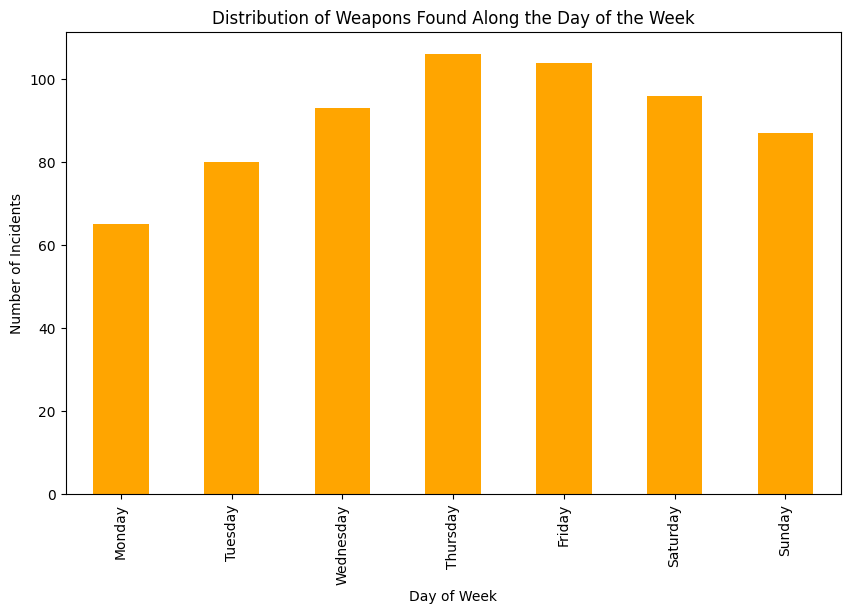

In [65]:
# Extract the day of the week
weapons_df['Day of Week'] = weapons_df['"OCCURRENCE DATE"'].dt.day_name()

# Order the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot the distribution of 'Weapons' force against MOS along the day of the week
plt.figure(figsize=(10, 6))
weapons_df['Day of Week'].value_counts().loc[days_order].plot(kind='bar', color='orange')
plt.title('Distribution of Weapons Found Along the Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Incidents')
plt.show()

### General EDA

#### Subject Gender Distribution

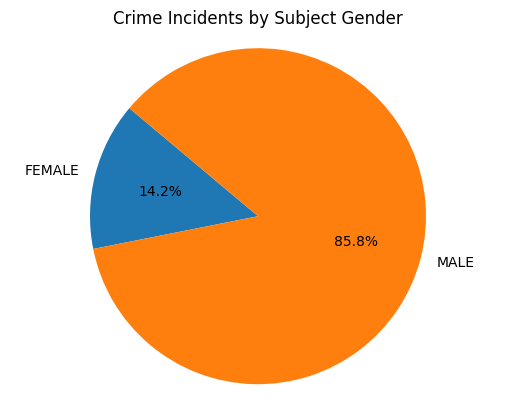

In [13]:
gender_data = use_of_force_combined_with_neighborhoods_pandas_df.groupby('"SUBJECT GENDER"').size()

# Plot
gender_data.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Crime Incidents by Subject Gender')
plt.show()

#### Subject Race Distribution

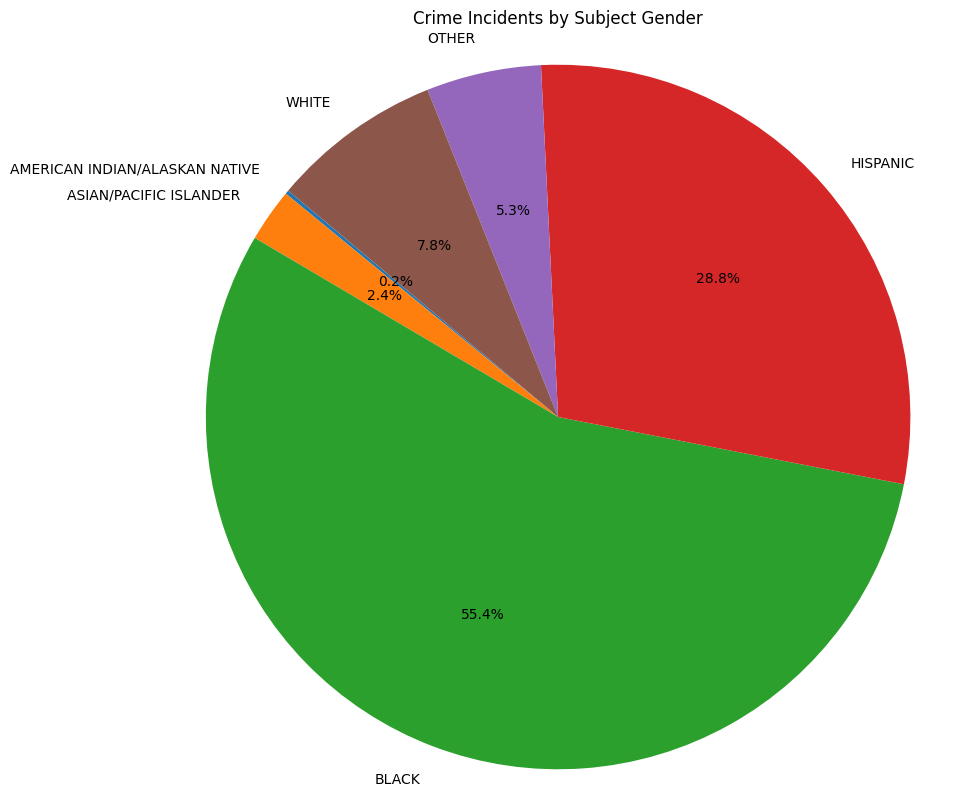

In [14]:
gender_data = use_of_force_combined_with_neighborhoods_pandas_df.groupby('"SUBJECT RACE"').size()

# Plot
plt.figure(figsize=(10, 10))  # Adjust the numbers (width, height) as needed

# Plot the pie chart
gender_data.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Crime Incidents by Subject Gender')

# Show the larger pie chart
plt.show()

In [16]:
use_of_force_combined_with_neighborhoods_pandas_df['"OCCURRENCE DATE"'] = pd.to_datetime(use_of_force_combined_with_neighborhoods_pandas_df['"OCCURRENCE DATE"'])

#### Day-wise Distribution

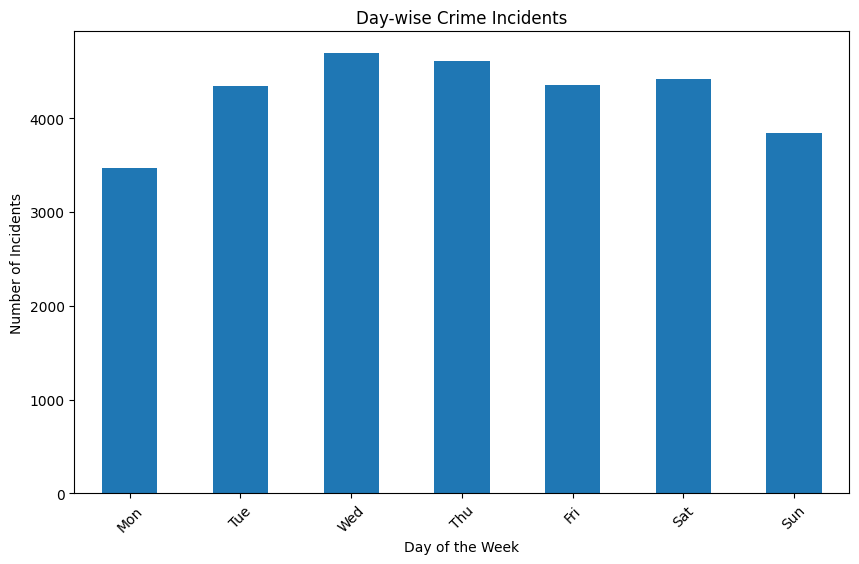

In [17]:
daywise_data=use_of_force_combined_with_neighborhoods_pandas_df['"OCCURRENCE DATE"'].dt.dayofweek.groupby(use_of_force_combined_with_neighborhoods_pandas_df['"OCCURRENCE DATE"'].dt.dayofweek).size()

# Plot
plt.figure(figsize=(10, 6))
daywise_data.plot(kind='bar')
plt.title('Day-wise Crime Incidents')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Incidents')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)
plt.show()

#### Month-wise Distribution

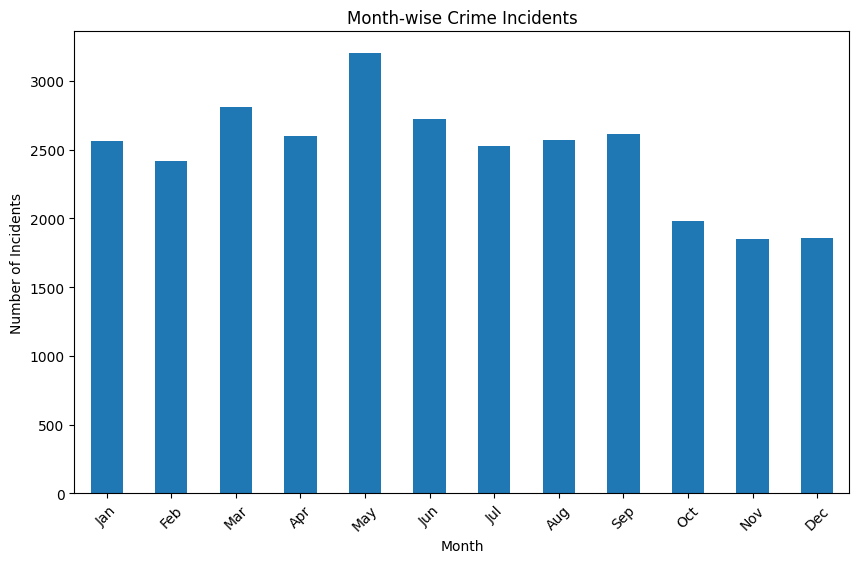

In [18]:
monthwise_data = use_of_force_combined_with_neighborhoods_pandas_df['"OCCURRENCE DATE"'].dt.month.groupby(use_of_force_combined_with_neighborhoods_pandas_df['"OCCURRENCE DATE"'].dt.month).size()

# Plot
plt.figure(figsize=(10, 6))
monthwise_data.plot(kind='bar')
plt.title('Month-wise Crime Incidents')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

#### Year-wise Distribution

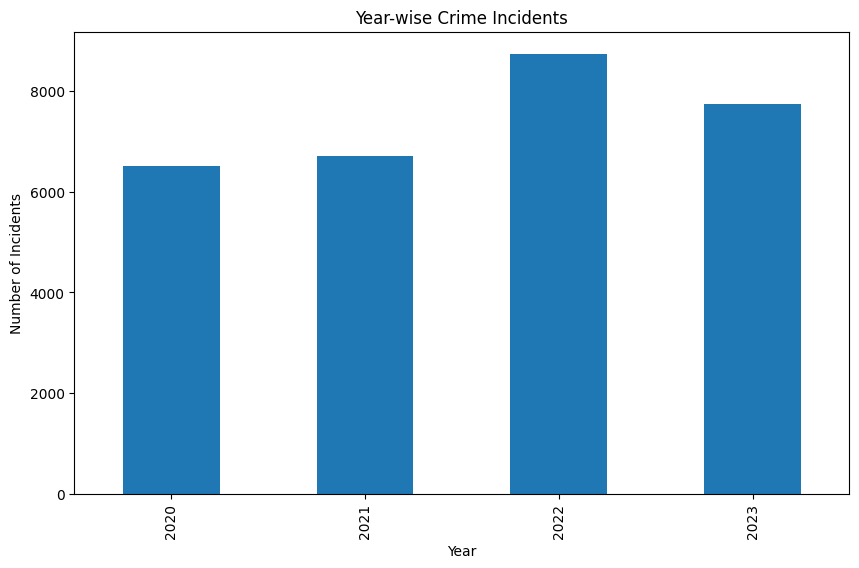

In [19]:
yearly_data=use_of_force_combined_with_neighborhoods_pandas_df['"OCCURRENCE DATE"'].dt.year.groupby(use_of_force_combined_with_neighborhoods_pandas_df['"OCCURRENCE DATE"'].dt.year).size()

# Plot
plt.figure(figsize=(10, 6))
yearly_data.plot(kind='bar')
plt.title('Year-wise Crime Incidents')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.show()

#### Top 10 Precincts - Borough-wise

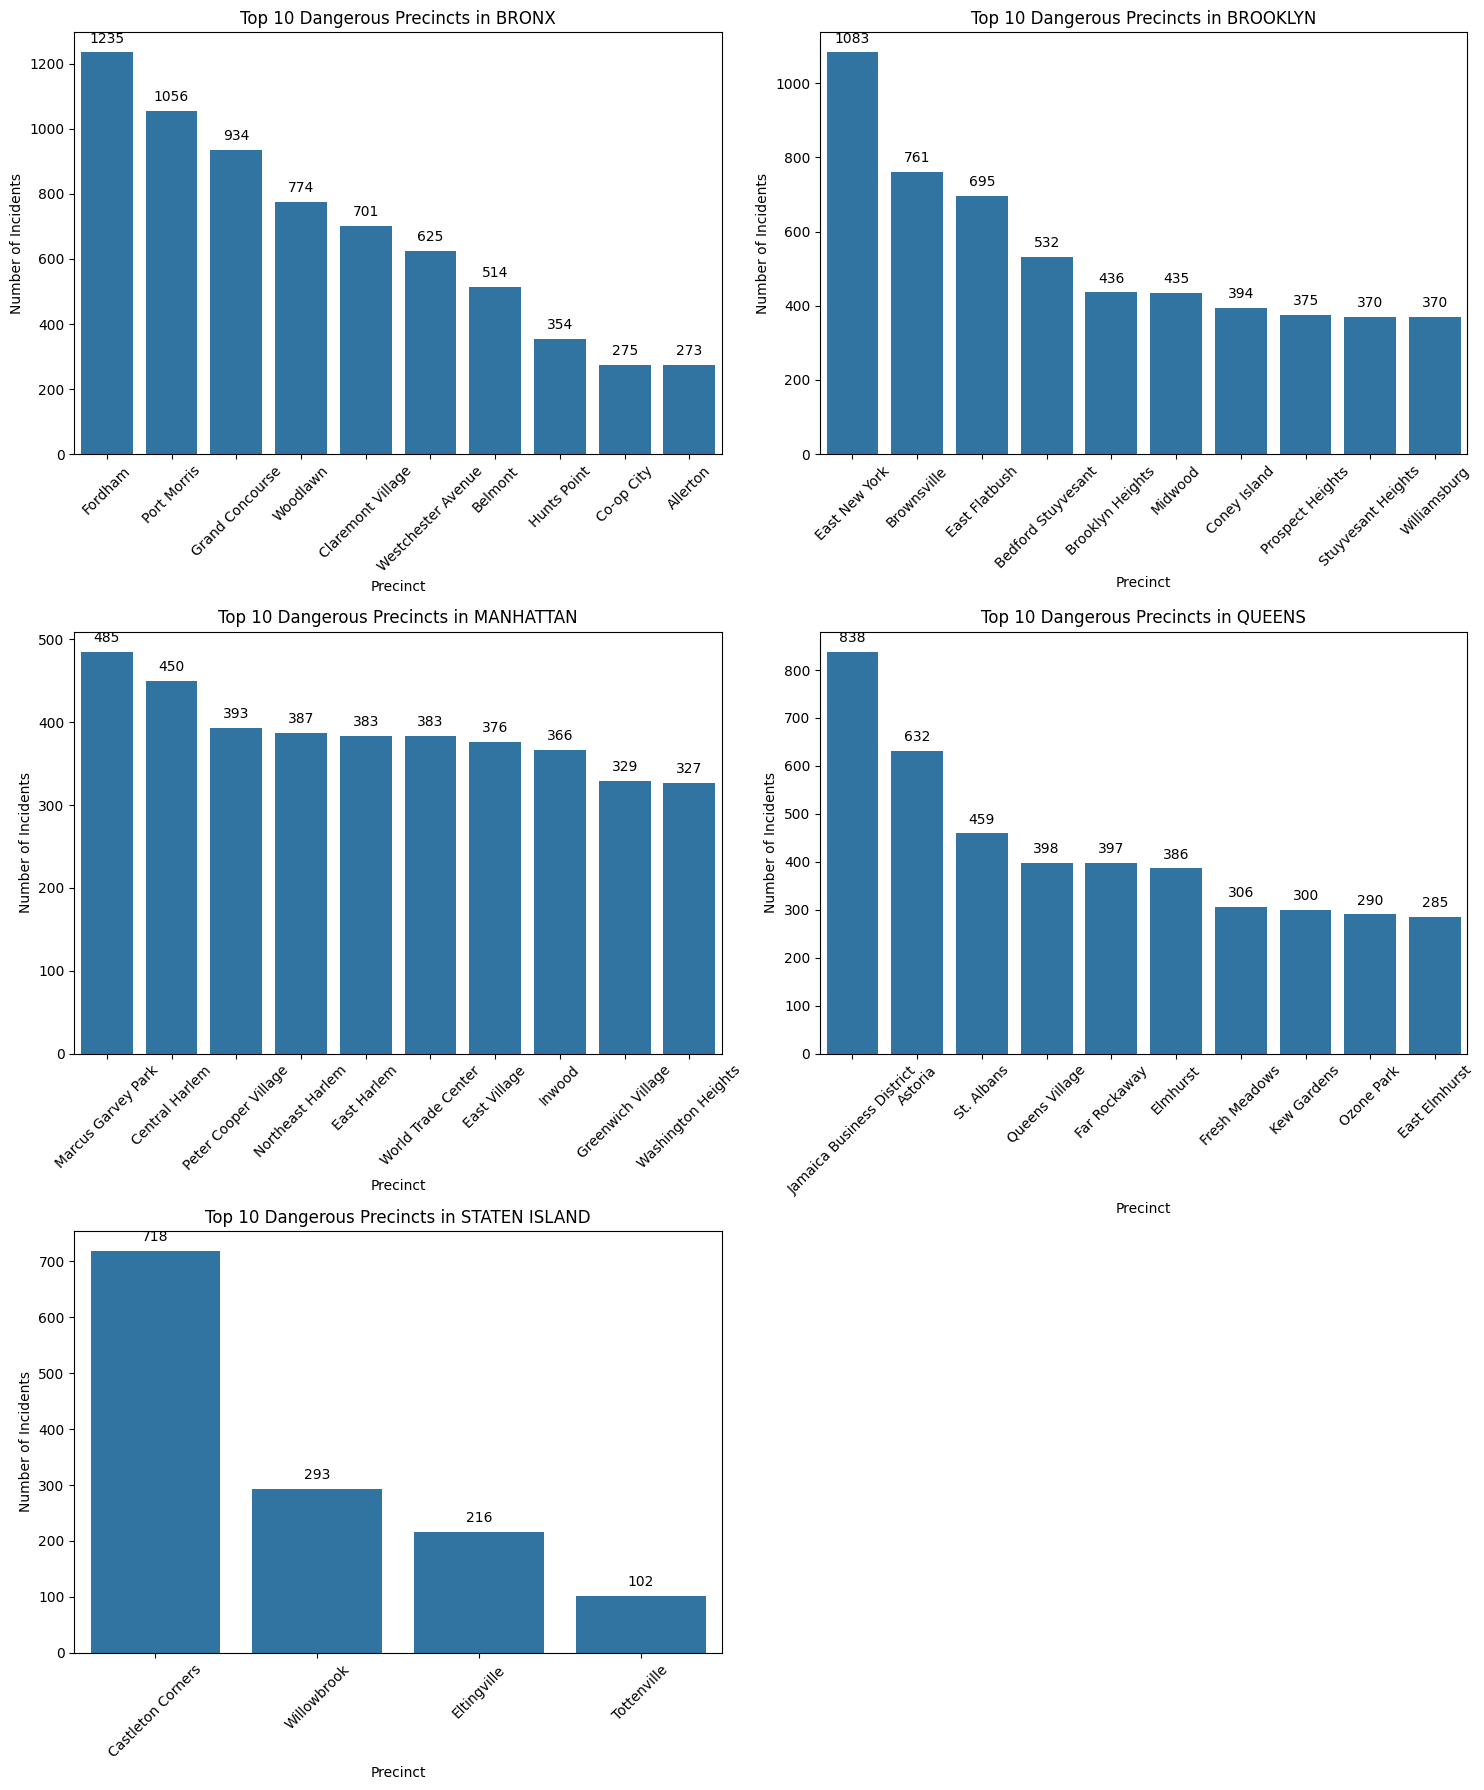

In [20]:
borough_precinct_data = use_of_force_combined_with_neighborhoods_pandas_df.groupby(['"PATROL BOROUGH"', 'NEIGHBORHOODS']).size().reset_index(name='counts')

# Get top 10 precincts for each borough
top_precincts = borough_precinct_data.groupby('"PATROL BOROUGH"').apply(lambda x: x.nlargest(10, 'counts')).reset_index(drop=True)

# Convert 'Incident Pct' to a string
top_precincts['NEIGHBORHOODS'] = top_precincts['NEIGHBORHOODS'].astype(str)

top_precincts['Short Neighborhood'] = top_precincts['NEIGHBORHOODS'].apply(lambda x: x.split('/')[0].strip())

# Unique list of boroughs
boroughs = top_precincts['"PATROL BOROUGH"'].unique()

# Determine the number of rows and columns needed for the subplots
num_rows = len(boroughs) // 2 + len(boroughs) % 2  # Add 1 if there's an odd number of boroughs
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 6))
axes = axes.flatten()  # Flatten the array for easy iteration

# Plot for each borough
for i, borough in enumerate(boroughs):
    borough_data = top_precincts[top_precincts['"PATROL BOROUGH"'] == borough]
    
    # Check if the current index exceeds the number of available axes
    if i < len(axes):
        ax = sns.barplot(data=borough_data, x='Short Neighborhood', y='counts', ax=axes[i])
        axes[i].set_title(f'Top 10 Dangerous Precincts in {borough}')
        axes[i].set_xlabel('Precinct')
        axes[i].set_ylabel('Number of Incidents')
        axes[i].tick_params(axis='x', rotation=45)

        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Remove any empty subplots
for j in range(len(boroughs), num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

#### Safest 10 Precincts - Borough-wise

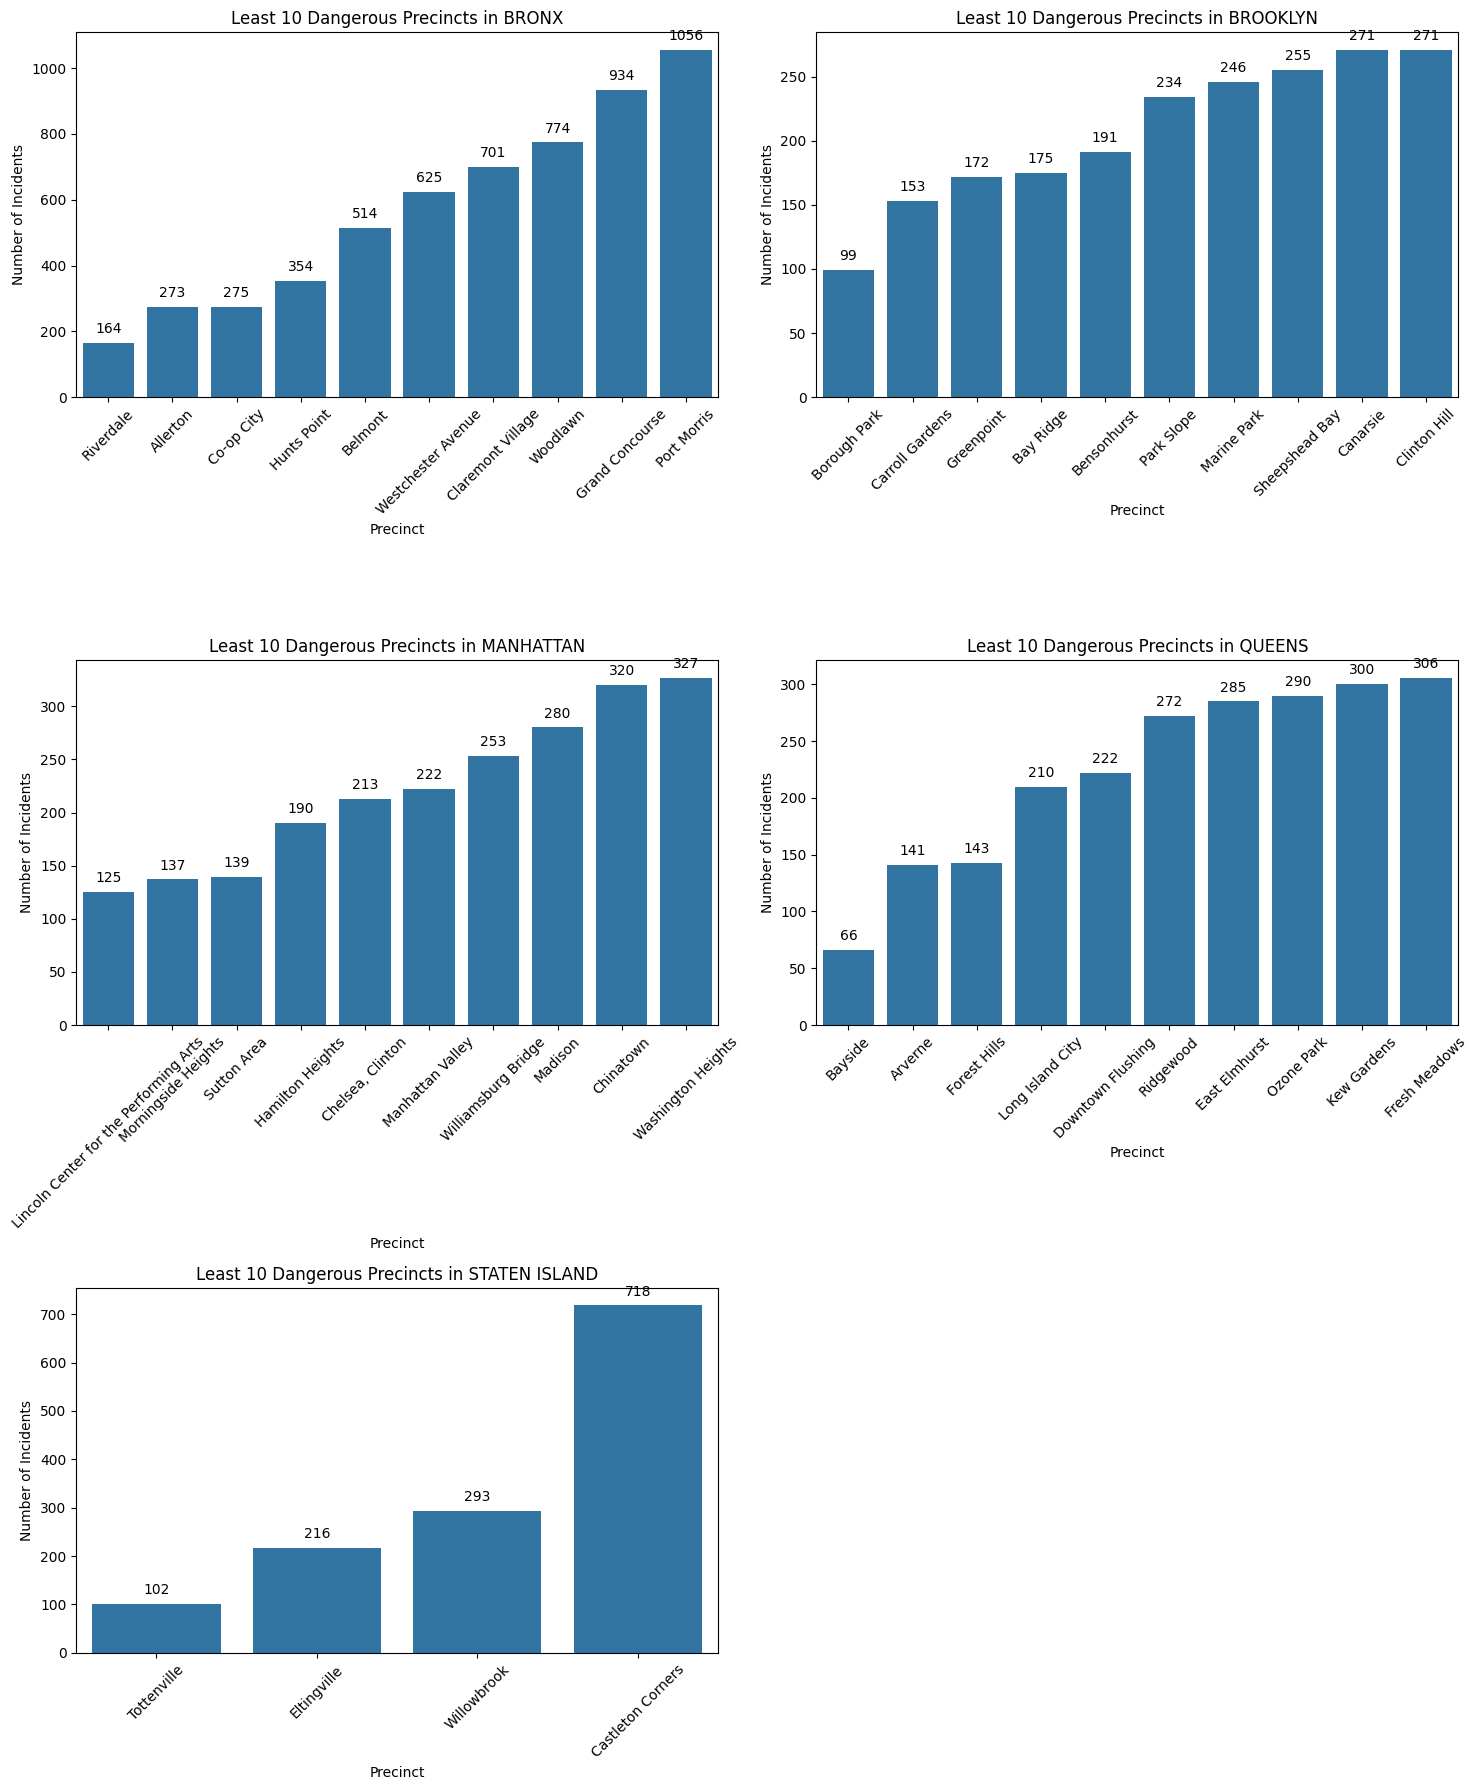

In [21]:
borough_precinct_data = use_of_force_combined_with_neighborhoods_pandas_df.groupby(['"PATROL BOROUGH"', 'NEIGHBORHOODS']).size().reset_index(name='counts')

# Get least 10 precincts for each borough
least_precincts = borough_precinct_data.groupby('"PATROL BOROUGH"').apply(lambda x: x.nsmallest(10, 'counts')).reset_index(drop=True)

# Convert 'Incident Pct' to a string
least_precincts['NEIGHBORHOODS'] = least_precincts['NEIGHBORHOODS'].astype(str)

least_precincts['Short Neighborhood'] = least_precincts['NEIGHBORHOODS'].apply(lambda x: x.split('/')[0].strip())

# Unique list of boroughs
boroughs = least_precincts['"PATROL BOROUGH"'].unique()

# Determine the number of rows and columns needed for the subplots
num_rows = len(boroughs) // 2 + len(boroughs) % 2  # Add 1 if there's an odd number of boroughs
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 6))
axes = axes.flatten()  # Flatten the array for easy iteration

# Plot for each borough
for i, borough in enumerate(boroughs):
    borough_data = least_precincts[least_precincts['"PATROL BOROUGH"'] == borough]
    
    # Check if the current index exceeds the number of available axes
    if i < len(axes):
        ax = sns.barplot(data=borough_data, x='Short Neighborhood', y='counts', ax=axes[i])
        axes[i].set_title(f'Least 10 Dangerous Precincts in {borough}')
        axes[i].set_xlabel('Precinct')
        axes[i].set_ylabel('Number of Incidents')
        axes[i].tick_params(axis='x', rotation=45)

        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Remove any empty subplots
for j in range(len(boroughs), num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()